In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import hamming_loss

In [ ]:
file = open('/content/drive/MyDrive/Other Files/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [ ]:
processedList[:100]

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [ ]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
data = pd.DataFrame(data = processedList, columns = columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [ ]:
data.shape

(343416, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [ ]:
data.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [ ]:
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [ ]:
Fs = 20
activities = data['activity'].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

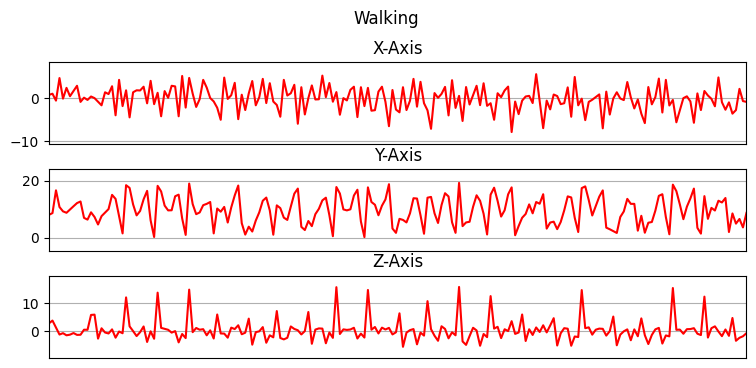

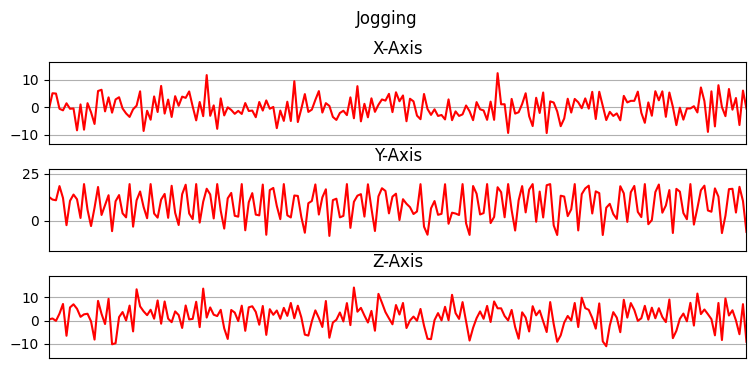

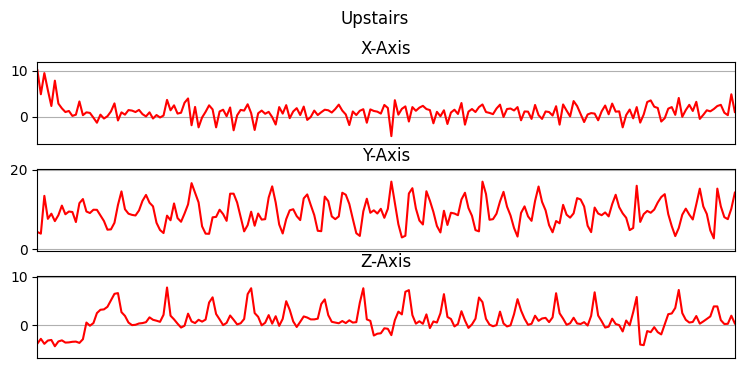

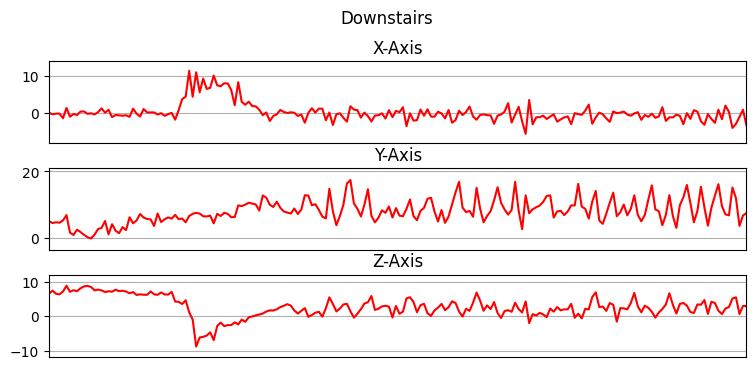

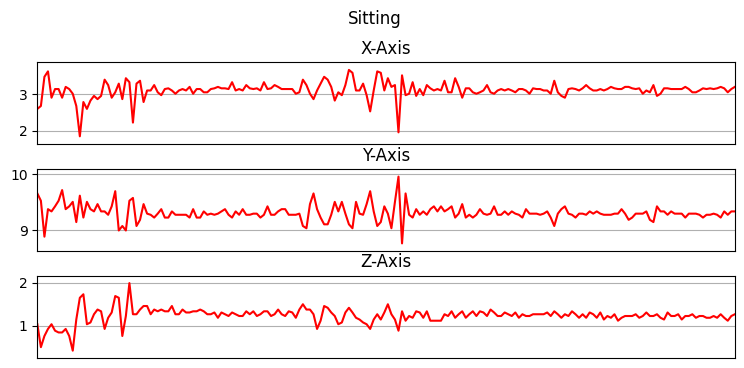

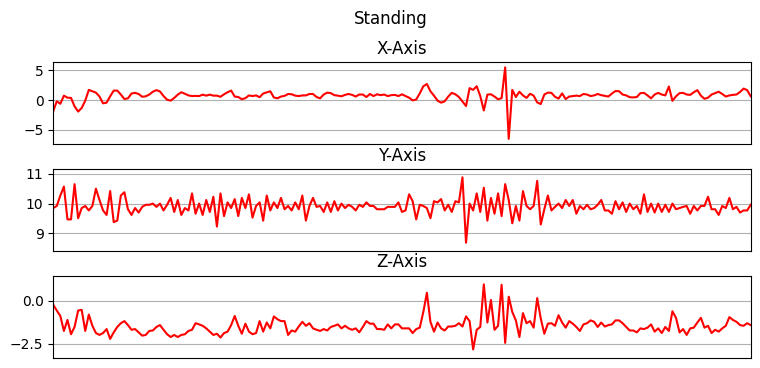

In [ ]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(9, 4), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [ ]:
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [ ]:
df['activity'].value_counts()

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: count, dtype: int64

In [ ]:
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()

balanced_data = pd.DataFrame()
balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(21330, 4)

In [ ]:
balanced_data['activity'].value_counts()

activity
Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: count, dtype: int64

In [ ]:
balanced_data.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [ ]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [ ]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [ ]:
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head()

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5


In [ ]:

X=scaled_X[['x','y','z']]

In [ ]:
X.isna().any()

x    False
y    False
z    False
dtype: bool

In [ ]:
X.isnull().any()

x    False
y    False
z    False
dtype: bool

In [ ]:
X.shape

(21330, 3)

In [ ]:
y=scaled_X[['label']]

In [ ]:
X[0:5]

,x,y,z
0,0.000503,-0.099190,0.337933
1,0.073590,0.020386,0.633446
2,-0.361275,1.588160,-0.103312
3,1.060258,0.437573,-0.844119
4,-0.237028,0.139962,-0.698386


In [ ]:
y[0:5]

,label
0,5
1,5
2,5
3,5
4,5


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
len(X_train)

17064

In [ ]:
X_train


,x,y,z
18680,-0.032889,0.252220,-0.912937
6503,0.227072,0.312683,-0.900793
8564,-0.142015,0.169191,-0.253093
16736,-1.570243,-2.102562,1.851932
3376,0.040701,0.437573,-0.981755
...,...,...,...
9372,-0.062402,0.115654,-0.034494
7291,0.329393,-0.532321,0.236730
17728,-1.406581,-2.102562,1.957183
7293,0.862925,-0.622667,1.681910


In [ ]:
len(X_test)

4266

In [ ]:
X_test

,x,y,z
16276,0.648590,0.152722,-0.184275
18358,0.238093,0.215152,-0.900793
14222,0.710299,0.072733,-0.265237
4295,2.014038,2.090380,0.920863
5188,1.725346,-1.534103,-1.277268
...,...,...,...
134,-1.212733,-0.869791,-0.629568
17269,-1.529998,-2.102562,1.864076
14244,0.543954,0.109801,-0.265237
20245,-0.470217,0.178084,0.329837


In [ ]:
X_train.shape

(17064, 3)

In [ ]:
y_train.shape

(17064, 1)

In [ ]:
X_test.shape

(4266, 3)

In [ ]:
y_test.shape

(4266, 1)

In [ ]:
#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define the KNN classifier
clf = KNeighborsClassifier()

In [ ]:
# Define the hyperparameters to tune
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2]}

In [ ]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [ ]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'n_neighbors': 11, 'p': 2}


In [ ]:
# Train the KNN classifier with the best hyperparameters
clf_best = grid_search.best_estimator_
clf_best.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=11)

In [ ]:
# Make predictions on the test set
y_pred = clf_best.predict(X_test_scaled)

In [ ]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7369901547116737


In [ ]:
# prompt: get the f1score of the above, also precision, and recall and accuracy in table form

import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Calculate the f1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the precision score
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate the recall score
recall = recall_score(y_test, y_pred, average='weighted')

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Create a table to display the results
table = pd.DataFrame({'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'],
                       'Score': [f1, precision, recall, accuracy]})

# Print the table
print(table.to_string())


      Metric     Score
0   F1 Score  0.735282
1  Precision  0.737834
2     Recall  0.736990
3   Accuracy  0.736990
